<a href="https://colab.research.google.com/github/YuvrajKhade/Machine-Learning-Project-Content_awareness_image_compression_using_Deep_Learning_and_SLIC_Algo/blob/main/Content_awareness_image_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycocotools

In [ ]:
# Create a directory for COCO
!mkdir -p /content/coco

# Download COCO 2017 training images
!wget -c http://images.cocodataset.org/zips/train2017.zip -P /content/coco
!unzip /content/coco/train2017.zip -d /content/coco

# Download COCO 2017 validation images
!wget -c http://images.cocodataset.org/zips/val2017.zip -P /content/coco
!unzip /content/coco/val2017.zip -d /content/coco

# Download COCO annotations
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/coco
!unzip /content/coco/annotations_trainval2017.zip -d /content/coco

Streaming output truncated to the last 5000 lines.
 extracting: /content/coco/val2017/000000577584.jpg  
 extracting: /content/coco/val2017/000000346905.jpg  
 extracting: /content/coco/val2017/000000433980.jpg  
 extracting: /content/coco/val2017/000000228144.jpg  
 extracting: /content/coco/val2017/000000041872.jpg  
 extracting: /content/coco/val2017/000000117492.jpg  
 extracting: /content/coco/val2017/000000368900.jpg  
 extracting: /content/coco/val2017/000000376900.jpg  
 extracting: /content/coco/val2017/000000352491.jpg  
 extracting: /content/coco/val2017/000000330790.jpg  
 extracting: /content/coco/val2017/000000384850.jpg  
 extracting: /content/coco/val2017/000000032735.jpg  
 extracting: /content/coco/val2017/000000197004.jpg  
 extracting: /content/coco/val2017/000000526751.jpg  
 extracting: /content/coco/val2017/000000041488.jpg  
 extracting: /content/coco/val2017/000000153632.jpg  
 extracting: /content/coco/val2017/000000501523.jpg  
 extracting: /content/coco/val2

In [ ]:
from pycocotools.coco import COCO

# Load COCO annotations
coco = COCO('/content/coco/annotations/instances_train2017.json')

# Get all categories
categories = coco.loadCats(coco.getCatIds())

# Print category IDs and names
for cat in categories:
    print(f"ID: {cat['id']}, Name: {cat['name']}")

loading annotations into memory...
Done (t=15.93s)
creating index...
index created!
ID: 1, Name: person
ID: 2, Name: bicycle
ID: 3, Name: car
ID: 4, Name: motorcycle
ID: 5, Name: airplane
ID: 6, Name: bus
ID: 7, Name: train
ID: 8, Name: truck
ID: 9, Name: boat
ID: 10, Name: traffic light
ID: 11, Name: fire hydrant
ID: 13, Name: stop sign
ID: 14, Name: parking meter
ID: 15, Name: bench
ID: 16, Name: bird
ID: 17, Name: cat
ID: 18, Name: dog
ID: 19, Name: horse
ID: 20, Name: sheep
ID: 21, Name: cow
ID: 22, Name: elephant
ID: 23, Name: bear
ID: 24, Name: zebra
ID: 25, Name: giraffe
ID: 27, Name: backpack
ID: 28, Name: umbrella
ID: 31, Name: handbag
ID: 32, Name: tie
ID: 33, Name: suitcase
ID: 34, Name: frisbee
ID: 35, Name: skis
ID: 36, Name: snowboard
ID: 37, Name: sports ball
ID: 38, Name: kite
ID: 39, Name: baseball bat
ID: 40, Name: baseball glove
ID: 41, Name: skateboard
ID: 42, Name: surfboard
ID: 43, Name: tennis racket
ID: 44, Name: bottle
ID: 46, Name: wine glass
ID: 47, Name: cup

In [ ]:
def define_importance_categories():
    # High importance: people, faces, text, animals, and main objects of interest
    high_importance_cats = [
        1,      # person
        2, 3, 4,  # bicycle, car, motorcycle (transportation)
        13, 14, 15, 16, 17, 18,  # animals (dog, cat, horse, sheep, cow, elephant)
        19, 20, 21, 22, 23,  # more animals (bear, zebra, giraffe, etc.)
        73, 74, 75, 76, 77  # laptop, mouse, remote, keyboard, cell phone (devices)
    ]

    # Medium importance: furniture, larger objects, context-providing elements
    medium_importance_cats = [
        5, 6, 7, 8, 9,  # airplane, bus, train, truck, boat
        10, 11, 12,  # traffic light, fire hydrant, stop sign
        24, 25, 26, 27,  # backpack, umbrella, handbag, tie
        28, 29, 30, 31, 32, 33,  # suitcase, frisbee, skis, snowboard, sports ball, kite
        34, 35, 36, 37, 38,  # baseball bat, baseball glove, skateboard, surfboard, tennis racket
        39, 40, 41, 42, 43, 44,  # bottle, wine glass, cup, fork, knife, spoon
        45, 46, 47, 48, 49, 50,  # bowl, banana, apple, sandwich, orange, broccoli
        61, 62, 63, 64, 65, 66, 67,  # chair, couch, potted plant, bed, dining table, toilet
        70, 71, 72,  # oven, toaster, sink
    ]

    # Create a set of all category IDs
    all_cats = set(range(1, 91))  # COCO has 90 categories

    # Low importance: everything else
    low_importance_cats = list(all_cats - set(high_importance_cats) - set(medium_importance_cats))

    return high_importance_cats, medium_importance_cats, low_importance_cats

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import random

class COCORegionImportanceDataset(Dataset):
    def __init__(self, coco_dir, annotation_file, transform=None):
        self.coco_dir = coco_dir
        self.transform = transform
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())

        # Define importance categories
        self.high_importance_cats, self.medium_importance_cats, _ = define_importance_categories()


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        image_path = os.path.join(self.coco_dir, img_info['file_name'])
        image = Image.open(image_path).convert('RGB')

        # Get annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Extract a patch and determine its importance
        patch, importance = self._extract_patch_with_importance(image, anns)

        if self.transform:
            patch = self.transform(patch)

        return patch, importance

    def _extract_patch_with_importance(self, image, anns):
        """Extract a random patch from the image and determine its importance level."""
        width, height = image.size

        # Define patch size (e.g., 224x224)
        patch_size = 224

        if len(anns) > 0:
            # Try to extract a patch containing an object
            selected_ann = random.choice(anns)
            bbox = selected_ann['bbox']  # [x, y, width, height]

            # Convert bbox to coordinates
            x1, y1 = int(bbox[0]), int(bbox[1])
            x2, y2 = min(x1 + int(bbox[2]), width), min(y1 + int(bbox[3]), height)

            # Get category and determine importance
            cat_id = selected_ann['category_id']
            if cat_id in self.high_importance_cats:
                importance = 0  # High importance
            elif cat_id in self.medium_importance_cats:
                importance = 1  # Medium importance
            else:
                importance = 2  # Low importance

            # Extract a patch around the object
            try:
                # Center the patch on the object
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2

                # Calculate patch boundaries
                patch_x1 = max(0, center_x - patch_size // 2)
                patch_y1 = max(0, center_y - patch_size // 2)
                patch_x2 = min(width, patch_x1 + patch_size)
                patch_y1 = min(height, patch_y1 + patch_size)

                # Adjust if patch goes out of bounds
                if patch_x2 - patch_x1 < patch_size:
                    patch_x1 = max(0, patch_x2 - patch_size)
                if patch_y2 - patch_y1 < patch_size:
                    patch_y1 = max(0, patch_y2 - patch_size)

                patch = image.crop((patch_x1, patch_y1, patch_x2, patch_y2))
                return patch, importance
            except:
                # If there's any error, fall back to random patch
                pass

        # Extract a random patch (usually for background)
        x = random.randint(0, max(0, width - patch_size))
        y = random.randint(0, max(0, height - patch_size))
        patch = image.crop((x, y, x + patch_size, y + patch_size))

        # Assume random patches are low importance (you may want to improve this logic)
        return patch, 2  # Low importance

loading annotations into memory...
Done (t=15.20s)
creating index...
index created!


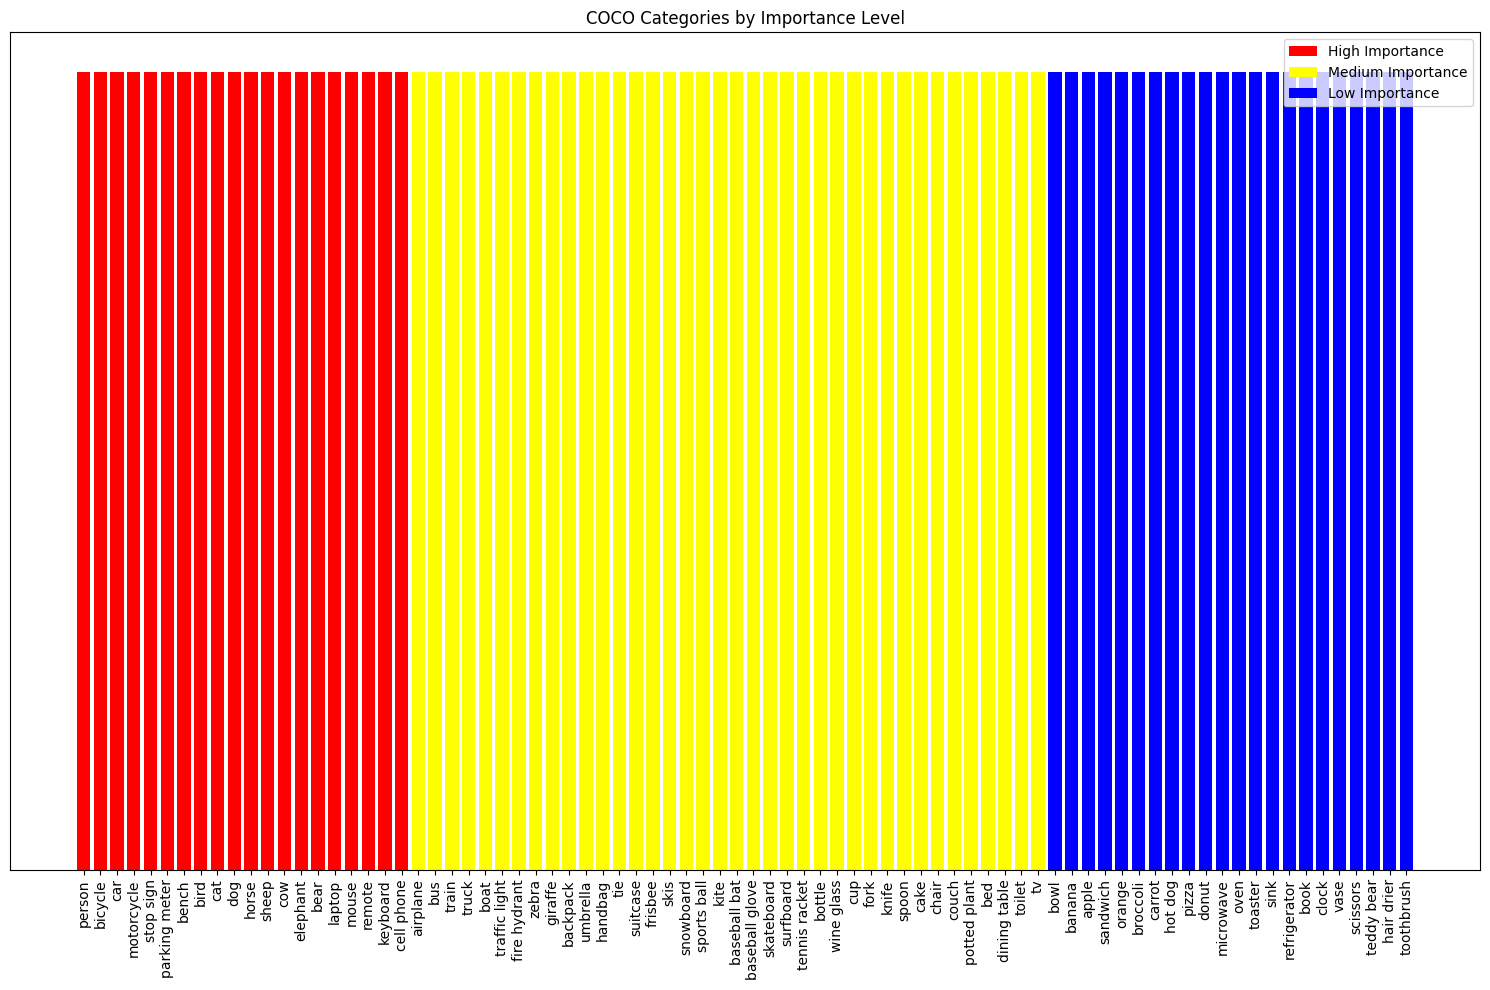

High importance categories: 20
Medium importance categories: 38
Low importance categories: 22


In [ ]:
def visualize_category_importance():
    high_cats, medium_cats, low_cats = define_importance_categories()

    coco = COCO('/content/coco/annotations/instances_train2017.json')
    categories = {cat['id']: cat['name'] for cat in coco.loadCats(coco.getCatIds())}

    # Create a visual representation
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots(figsize=(15, 10))

    # High importance
    high_names = [categories[cat_id] for cat_id in high_cats if cat_id in categories]
    ax.bar(np.arange(len(high_names)), [1] * len(high_names), color='red', label='High Importance')

    # Medium importance
    medium_names = [categories[cat_id] for cat_id in medium_cats if cat_id in categories]
    ax.bar(np.arange(len(high_names), len(high_names) + len(medium_names)),
           [1] * len(medium_names), color='yellow', label='Medium Importance')

    # Low importance
    low_names = [categories[cat_id] for cat_id in low_cats if cat_id in categories]
    ax.bar(np.arange(len(high_names) + len(medium_names),
                     len(high_names) + len(medium_names) + len(low_names)),
           [1] * len(low_names), color='blue', label='Low Importance')

    # Set labels
    all_names = high_names + medium_names + low_names
    plt.xticks(np.arange(len(all_names)), all_names, rotation=90)
    plt.yticks([])
    plt.legend()
    plt.title('COCO Categories by Importance Level')
    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"High importance categories: {len(high_names)}")
    print(f"Medium importance categories: {len(medium_names)}")
    print(f"Low importance categories: {len(low_names)}")

    return high_names, medium_names, low_names

# Call this function to see and verify your category assignments
high_names, medium_names, low_names = visualize_category_importance()

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset
coco_train_dir = '/content/coco/train2017'
coco_val_dir = '/content/coco/val2017'
train_ann_file = '/content/coco/annotations/instances_train2017.json'
val_ann_file = '/content/coco/annotations/instances_val2017.json'

# You might want to use a subset of COCO if storage is an issue
train_dataset = COCORegionImportanceDataset(
    coco_dir=coco_train_dir,
    annotation_file=train_ann_file,
    transform=transform
)

val_dataset = COCORegionImportanceDataset(
    coco_dir=coco_val_dir,
    annotation_file=val_ann_file,
    transform=transform
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=2
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False, num_workers=2
)

loading annotations into memory...
Done (t=16.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms

# 1. Use a smaller backbone network
class LightweightImportanceNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LightweightImportanceNet, self).__init__()
        # Use MobileNetV2 instead of ResNet18 - much faster and smaller
        self.model = models.mobilenet_v2(pretrained=True)

        # Replace the classifier
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# 2. Use transfer learning more effectively
def train_importance_model(train_loader, val_loader=None, num_epochs=5):
    model = LightweightImportanceNet(num_classes=3)

    # 3. Freeze most layers to speed up training
    # Only train the classifier layers initially
    for param in model.model.features.parameters():
        param.requires_grad = False

    # Use a higher learning rate since we're only training a few layers
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # 4. Early stopping implementation
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0

    # 5. Mixed precision training for faster computation on compatible GPUs
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Mixed precision forward pass
            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                # Mixed precision backward pass and optimization
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Regular forward/backward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # 6. Print batch progress less frequently
            if i % 100 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {i}/{len(train_loader)}, Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Validation phase
        if val_loader:
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)

            val_loss = val_loss / len(val_loader.dataset)
            print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model
                torch.save(model.state_dict(), 'best_importance_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Early stopping triggered after {epoch+1} epochs')
                    break

    # 7. Fine-tune the model after initial training
    if epoch == num_epochs - 1 or patience_counter >= patience:
        print("Fine-tuning the model...")
        # Unfreeze all layers for fine-tuning
        for param in model.parameters():
            param.requires_grad = True

        # Lower learning rate for fine-tuning
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        # Train for a few more epochs
        for epoch in range(2):
            model.train()
            running_loss = 0.0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            print(f'Fine-tuning Epoch {epoch+1}/2, Loss: {epoch_loss:.4f}')

    return model

# 8. Data loading optimization
def create_efficient_data_loaders(train_dataset, val_dataset=None, batch_size=32):
    # Use more workers for data loading
    num_workers = 4

    # Pin memory for faster data transfer to GPU
    pin_memory = torch.cuda.is_available()

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    val_loader = None
    if val_dataset:
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory
        )

    return train_loader, val_loader

# 9. Use a smaller subset of data for initial experiments
def create_smaller_dataset(dataset, fraction=0.2):
    """Create a smaller subset of the dataset for faster training"""
    from torch.utils.data import Subset
    import numpy as np

    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    subset_size = int(np.floor(dataset_size * fraction))

    # Random selection
    np.random.shuffle(indices)
    subset_indices = indices[:subset_size]

    return Subset(dataset, subset_indices)

# Usage example
if __name__ == "__main__":
    # Create smaller dataset for experimentation
    small_train_dataset = create_smaller_dataset(train_dataset, fraction=0.2)
    small_val_dataset = create_smaller_dataset(val_dataset, fraction=0.2)

    # Create optimized data loaders
    train_loader, val_loader = create_efficient_data_loaders(
        small_train_dataset,
        small_val_dataset,
        batch_size=64  # Larger batch size for faster training
    )

    # Train the model
    model = train_importance_model(train_loader, val_loader, num_epochs=5)

    # Save the final model
    torch.save(model.state_dict(), 'region_importance_model_final.pth')

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b03531

Epoch 1/5, Batch 0/370, Loss: 0.9626
Epoch 1/5, Batch 100/370, Loss: 0.0001
Epoch 1/5, Batch 200/370, Loss: 0.0000
Epoch 1/5, Batch 300/370, Loss: 0.0009
Epoch 1/5, Training Loss: 0.0048
Epoch 1/5, Validation Loss: 0.0002
Epoch 2/5, Batch 0/370, Loss: 0.0001
Epoch 2/5, Batch 100/370, Loss: 0.0005
Epoch 2/5, Batch 200/370, Loss: 0.0000
Epoch 2/5, Batch 300/370, Loss: 0.0000
Epoch 2/5, Training Loss: 0.0001
Epoch 2/5, Validation Loss: 0.0001
Epoch 3/5, Batch 0/370, Loss: 0.0000
Epoch 3/5, Batch 100/370, Loss: 0.0001
Epoch 3/5, Batch 200/370, Loss: 0.0002
Epoch 3/5, Batch 300/370, Loss: 0.0000
Epoch 3/5, Training Loss: 0.0001
Epoch 3/5, Validation Loss: 0.0001
Epoch 4/5, Batch 0/370, Loss: 0.0001
Epoch 4/5, Batch 100/370, Loss: 0.0001
Epoch 4/5, Batch 200/370, Loss: 0.0000
Epoch 4/5, Batch 300/370, Loss: 0.0000
Epoch 4/5, Training Loss: 0.0001
Epoch 4/5, Validation Loss: 0.0000
Epoch 5/5, Batch 0/370, Loss: 0.0000
Epoch 5/5, Batch 100/370, Loss: 0.0000
Epoch 5/5, Batch 200/370, Loss: 0.00

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import numpy as np

# Model with Partial Unfreezing
class LightweightImportanceNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LightweightImportanceNet, self).__init__()
        self.model = models.mobilenet_v2(pretrained=True)
        self.model.features = nn.Sequential(
            *self.model.features,
            nn.Dropout(0.5)
        )
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)


def train_importance_model(train_loader, val_loader=None, num_epochs=10):
    model = LightweightImportanceNet(num_classes=3)


    for param in model.model.features[-5:].parameters():
        param.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = (correct_train / total_train) * 100
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%')


        if val_loader:
            model.eval()
            val_loss, correct_val, total_val = 0.0, 0, 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    correct_val += (predicted == labels).sum().item()
                    total_val += labels.size(0)

            val_loss = val_loss / len(val_loader.dataset)
            val_acc = (correct_val / total_val) * 100
            print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')


            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), 'best_importance_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Early stopping triggered after {epoch+1} epochs')
                    break

    return model


def create_smaller_dataset(dataset, fraction=0.5):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    subset_size = int(np.floor(dataset_size * fraction))
    np.random.shuffle(indices)
    subset_indices = indices[:subset_size]
    return Subset(dataset, subset_indices)


def create_efficient_data_loaders(train_dataset, val_dataset, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, val_loader


if __name__ == "__main__":
    small_train_dataset = create_smaller_dataset(train_dataset, fraction=0.8)
    small_val_dataset = create_smaller_dataset(val_dataset, fraction=0.2)
    train_loader, val_loader = create_efficient_data_loaders(small_train_dataset, small_val_dataset, batch_size=32)
    model = train_importance_model(train_loader, val_loader, num_epochs=5)
    torch.save(model.state_dict(), 'region_importance_model_final.pth')


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b03531

Epoch 1/5, Training Loss: 0.2960, Training Accuracy: 99.92%
Epoch 1/5, Validation Loss: 0.2912, Validation Accuracy: 100.00%
Epoch 2/5, Training Loss: 0.2915, Training Accuracy: 100.00%
Epoch 2/5, Validation Loss: 0.2912, Validation Accuracy: 100.00%
Epoch 3/5, Training Loss: 0.2914, Training Accuracy: 100.00%
Epoch 3/5, Validation Loss: 0.2911, Validation Accuracy: 100.00%
Epoch 4/5, Training Loss: 0.2913, Training Accuracy: 100.00%
Epoch 4/5, Validation Loss: 0.2916, Validation Accuracy: 100.00%
Epoch 5/5, Training Loss: 0.2913, Training Accuracy: 100.00%
Epoch 5/5, Validation Loss: 0.2914, Validation Accuracy: 100.00%


new code


In [ ]:
pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.5 MB/s eta 0:00:00


Saving baby.jpg to baby (4).jpg
Uploaded file: baby (4).jpg
Model loaded successfully to cuda
Generating importance heatmap...
Processed 10/64 patches (15.6%)
Processed 20/64 patches (31.2%)
Processed 30/64 patches (46.9%)
Processed 40/64 patches (62.5%)
Processed 50/64 patches (78.1%)
Processed 60/64 patches (93.8%)
Processed 64/64 patches (100.0%)


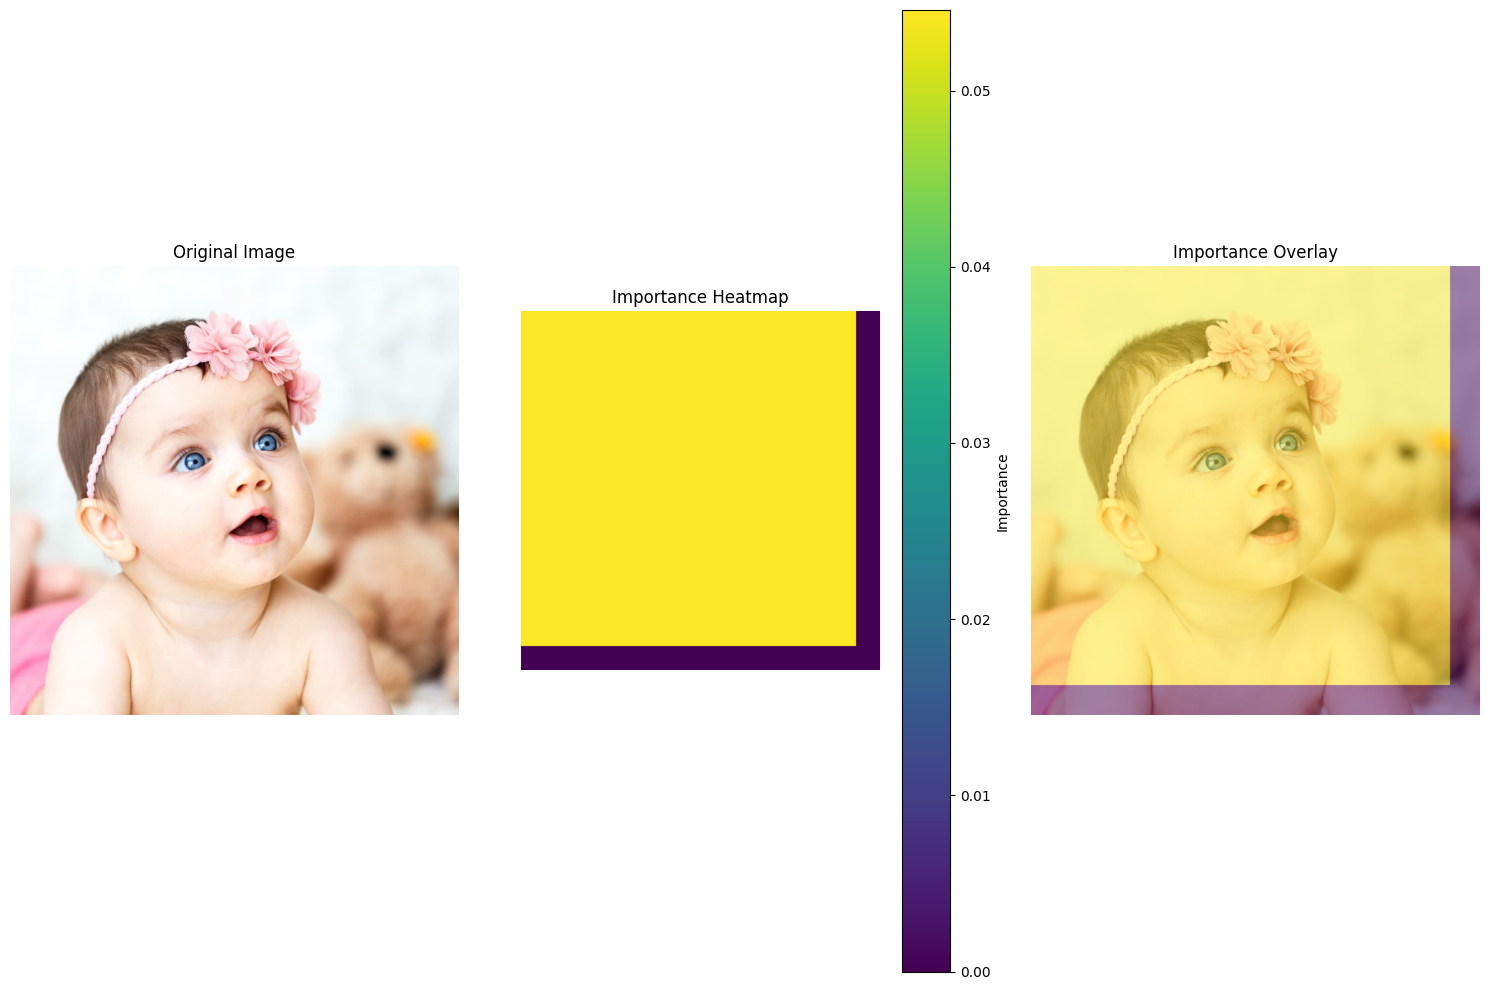

Segmenting image...
Applying SLIC segmentation...


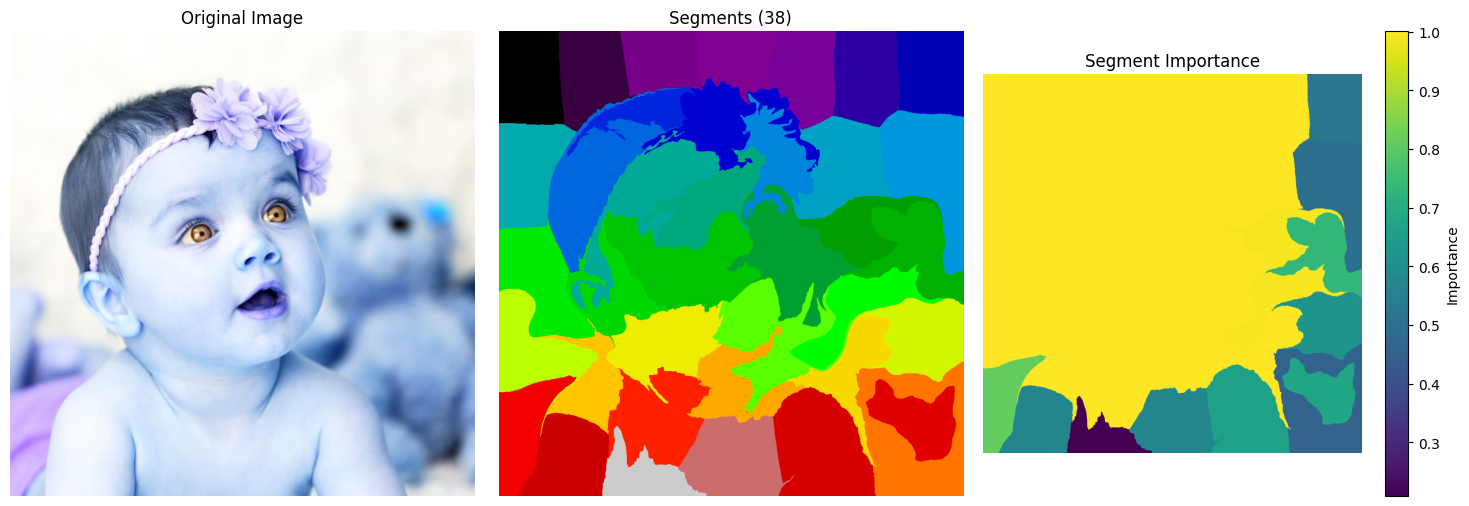

Creating quality map...
Applying variable compression...


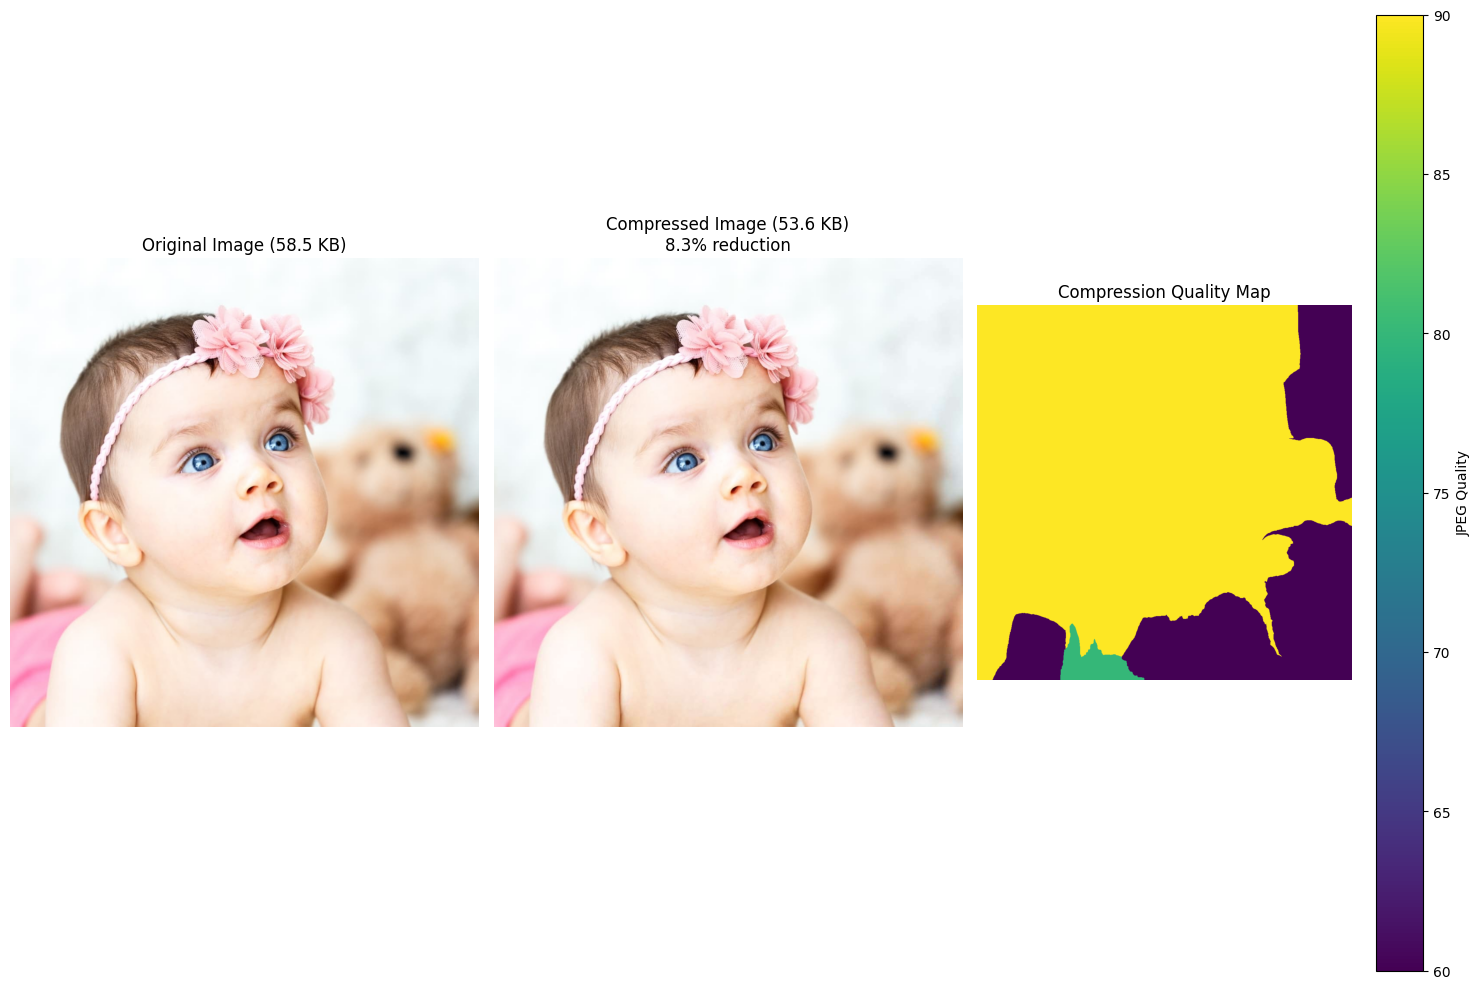

Compression complete in 12.49 seconds
Original size: 58.5 KB
Compressed size: 53.6 KB
Size reduction: 8.3%
Segment compression stats: {'high': 29, 'medium': 8, 'low': 1}
Successfully compressed image with 8.3% size reduction


In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import maximum_filter, generate_binary_structure
import os
import cv2
from skimage.segmentation import slic
from skimage.measure import regionprops
from skimage import graph
import time
class RegionImportanceAnalyzer:
    """
    Class for analyzing region importance in images using a trained CNN model.
    """
    def __init__(self, model_path=None):
        """
        Initialize the analyzer with a trained model.

        Args:
            model_path: Path to the saved model (optional)
        """
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        if model_path and os.path.exists(model_path):
            self.load_model(model_path)

    def load_model(self, model_path):
        """
        Load the trained model from a file.

        Args:
            model_path: Path to the saved model
        """
        # Note: The RegionImportanceCNN class is assumed to be defined elsewhere
        # You might need to adjust this based on your actual model definition
        # from models import RegionImportanceCNN  # Assuming this is imported from a models.py file

        self.model = LightweightImportanceNet(num_classes=3)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

        print(f"Model loaded successfully to {self.device}")

    def predict_region_importance(self, image_path, patch_size=224, stride=112):
        """
        Predict importance of regions in an image using sliding window approach.

        Args:
            image_path: Path to the image file or PIL Image object
            patch_size: Size of the patches to extract (default: 224)
            stride: Stride between patches (default: 112)

        Returns:
            Original image and importance heatmap
        """
        if self.model is None:
            raise ValueError("Model has not been loaded. Call load_model() first.")

        # Load the image
        if isinstance(image_path, str):
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Image file not found: {image_path}")
            image = Image.open(image_path).convert('RGB')
        elif isinstance(image_path, Image.Image):
            image = image_path
        else:
            raise TypeError("image_path must be a string or PIL Image object")

        width, height = image.size

        # Create an empty heatmap
        heatmap = np.zeros((height, width))
        count = np.zeros((height, width))

        # Slide window over the image with progress tracking
        total_patches = ((height - patch_size + stride) // stride) * ((width - patch_size + stride) // stride)
        processed_patches = 0

        for y in range(0, height - patch_size + 1, stride):
            for x in range(0, width - patch_size + 1, stride):
                # Extract patch
                patch = image.crop((x, y, x + patch_size, y + patch_size))
                patch_tensor = self.transform(patch).unsqueeze(0).to(self.device)

                # Make prediction
                with torch.no_grad():
                    output = self.model(patch_tensor)
                    probabilities = torch.softmax(output, dim=1)

                    # Get importance score (high importance = 1.0, medium = 0.5, low = 0.0)
                    importance_score = (1.0 * probabilities[0, 0] + 0.5 * probabilities[0, 1]).item()

                # Update heatmap
                heatmap[y:y+patch_size, x:x+patch_size] += importance_score
                count[y:y+patch_size, x:x+patch_size] += 1

                # Update progress
                processed_patches += 1
                if processed_patches % 10 == 0 or processed_patches == total_patches:
                    print(f"Processed {processed_patches}/{total_patches} patches ({processed_patches/total_patches*100:.1f}%)")

        # Average the heatmap values
        mask = count > 0
        heatmap[mask] /= count[mask]

        return image, heatmap

    def find_important_regions(self, heatmap, importance_threshold=0.7, region_size=112, max_regions=5):
        """
        Find regions of high importance in the heatmap.

        Args:
            heatmap: The importance heatmap
            importance_threshold: Threshold for determining high importance (default: 0.7)
            region_size: Size of the regions to identify (default: 112)
            max_regions: Maximum number of regions to return (default: 5)

        Returns:
            List of important regions with their coordinates and importance scores
        """
        height, width = heatmap.shape

        # Find peaks in the heatmap
        struct = generate_binary_structure(2, 2)
        filtered = maximum_filter(heatmap, size=25)
        peaks = (heatmap == filtered) & (heatmap > importance_threshold)
        peak_coords = np.where(peaks)

        # Group nearby peaks
        processed = set()
        regions = []

        for y, x in zip(peak_coords[0], peak_coords[1]):
            if (y, x) not in processed:
                # Define a region around this peak
                half_size = region_size // 2
                region = {
                    'y': max(0, y - half_size),
                    'x': max(0, x - half_size),
                    'height': min(region_size, height - max(0, y - half_size)),
                    'width': min(region_size, width - max(0, x - half_size)),
                    'center_y': y,
                    'center_x': x,
                    'importance': heatmap[y, x]
                }
                regions.append(region)

                # Mark points in this region as processed
                for dy in range(max(0, y - region_size), min(height, y + region_size)):
                    for dx in range(max(0, x - region_size), min(width, x + region_size)):
                        processed.add((dy, dx))

        # Sort regions by importance
        regions.sort(key=lambda r: r['importance'], reverse=True)

        return regions[:max_regions]

    def visualize_importance(self, image, heatmap, regions=None, save_path=None):
        """
        Visualize the importance heatmap and top regions.

        Args:
            image: Original PIL image
            heatmap: Importance heatmap
            regions: List of important regions (optional)
            save_path: Path to save the visualization (optional)
        """
        # Create a figure with subplots
        fig = plt.figure(figsize=(15, 10))

        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        # Plot heatmap
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='viridis')
        plt.title('Importance Heatmap')
        plt.colorbar(label='Importance')
        plt.axis('off')

        # Plot overlay
        plt.subplot(1, 3, 3)
        plt.imshow(image)
        plt.imshow(heatmap, cmap='viridis', alpha=0.5)
        plt.title('Importance Overlay')
        plt.axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(f"{save_path}_heatmap.png", dpi=300, bbox_inches='tight')

        plt.show()

        # Plot top regions if provided
        if regions:
            plt.figure(figsize=(10, 10))
            plt.imshow(image)

            for i, region in enumerate(regions):
                rect = patches.Rectangle(
                    (region['x'], region['y']),
                    region['width'],
                    region['height'],
                    linewidth=2,
                    edgecolor='r',
                    facecolor='none'
                )
                plt.gca().add_patch(rect)
                plt.text(
                    region['x'],
                    region['y'] - 5,
                    f"Region {i+1}: {region['importance']:.2f}",
                    color='white',
                    fontsize=12,
                    bbox=dict(facecolor='red', alpha=0.5)
                )

            plt.title('Top Important Regions')
            plt.axis('off')
            plt.tight_layout()

            if save_path:
                plt.savefig(f"{save_path}_regions.png", dpi=300, bbox_inches='tight')

            plt.show()

    def analyze_image(self, image_path, patch_size=224, stride=112, importance_threshold=0.7,
                      max_regions=5, save_path=None):
        """
        Complete analysis of an image: predicting importance, finding regions, and visualizing.

        Args:
            image_path: Path to the image file
            patch_size: Size of the patches to extract
            stride: Stride between patches
            importance_threshold: Threshold for determining high importance
            max_regions: Maximum number of regions to return
            save_path: Path to save the visualization (optional)

        Returns:
            List of important regions
        """
        # Predict importance
        image, heatmap = self.predict_region_importance(image_path, patch_size, stride)

        # Find important regions
        regions = self.find_important_regions(heatmap, importance_threshold, patch_size // 2, max_regions)

        # Visualize results
        self.visualize_importance(image, heatmap, regions, save_path)

        return image, heatmap, regions


class ContentAwareCompressor:
    """
    Class for performing content-aware image compression using importance maps.
    """
    def __init__(self, model_path=None):
        """
        Initialize the compressor with a trained model.

        Args:
            model_path: Path to the saved importance model (optional)
        """
        self.analyzer = RegionImportanceAnalyzer(model_path)

    def apply_graph_coloring(self, image, heatmap, n_segments=100):
        """
        Apply graph coloring to segment the image based on the importance heatmap.

        Args:
            image: PIL Image or numpy array
            heatmap: Importance heatmap
            n_segments: Number of segments to create

        Returns:
            Dictionary with segment information
        """
        # Convert PIL Image to numpy array if needed
        if isinstance(image, Image.Image):
            img_array = np.array(image)
        else:
            img_array = image

        # Normalize heatmap to 0-1 if it's not already
        heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

        # Use SLIC to get segments
        print("Applying SLIC segmentation...")
        segments = slic(img_array, n_segments=n_segments, compactness=10, sigma=1)

        # Create a RAG (Region Adjacency Graph)
        g = graph.rag_mean_color(img_array, segments)

        # Calculate average importance for each segment
        segment_importance = {}
        for segment_id in np.unique(segments):
            mask = segments == segment_id
            avg_importance = np.mean(heatmap_norm[mask])
            segment_importance[segment_id] = avg_importance

        # Visualize segments
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img_array)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(segments, cmap='nipy_spectral')
        plt.title(f'Segments ({len(np.unique(segments))})')
        plt.axis('off')

        # Create a visualization of segment importance
        importance_vis = np.zeros_like(segments, dtype=float)
        for segment_id, importance in segment_importance.items():
            importance_vis[segments == segment_id] = importance

        plt.subplot(1, 3, 3)
        plt.imshow(importance_vis, cmap='viridis')
        plt.title('Segment Importance')
        plt.colorbar(label='Importance')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        return {
            'segments': segments,
            'importance': segment_importance,
            'n_segments': len(np.unique(segments))
        }

    def compress_segment(self, image, segment_mask, quality, temp_dir='temp'):
        """
        Compress a specific segment of the image with the given quality.

        Args:
            image: Numpy array of the image
            segment_mask: Binary mask of the segment
            quality: JPEG quality (0-100)
            temp_dir: Directory for temporary files

        Returns:
            Compressed segment
        """
        # Create temp directory if it doesn't exist
        os.makedirs(temp_dir, exist_ok=True)

        # Create a copy of the image and set non-segment pixels to black
        segment_img = image.copy()
        segment_img[~segment_mask] = 0

        # Save the segment to a temporary file with the specified quality
        temp_file = os.path.join(temp_dir, f'segment_{np.random.randint(10000)}.jpg')
        cv2.imwrite(temp_file, segment_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

        # Read the compressed segment back
        compressed_segment = cv2.imread(temp_file)

        # Clean up
        os.remove(temp_file)

        return compressed_segment


    def content_aware_compress(self, image_path, output_path, quality_high=90, quality_medium=60, quality_low=30,
                           n_segments=100, visualize=True):
        """
        Perform content-aware compression on an image.

        Args:
            image_path: Path to the input image
            output_path: Path to save the compressed image
            quality_high: JPEG quality for high importance regions (0-100)
            quality_medium: JPEG quality for medium importance regions (0-100)
            quality_low: JPEG quality for low importance regions (0-100)
            n_segments: Number of segments to create
            visualize: Whether to visualize the results

        Returns:
            Compressed image, file size reduction percentage
        """
        start_time = time.time()

        # 1. Load image
        if isinstance(image_path, str):
            img_cv = cv2.imread(image_path)
            img_pil = Image.open(image_path).convert('RGB')
        else:
            raise TypeError("image_path must be a string")

        original_size = os.path.getsize(image_path) if os.path.exists(image_path) else None

        # 2. Generate importance heatmap using the CNN
        print("Generating importance heatmap...")
        _, heatmap, _ = self.analyzer.analyze_image(image_path, save_path=None if not visualize else
                                                  os.path.splitext(output_path)[0] + "_analysis")

        # 3. Segment image using graph coloring
        print("Segmenting image...")
        segmentation = self.apply_graph_coloring(img_cv, heatmap, n_segments)
        segments = segmentation['segments']
        segment_importance = segmentation['importance']

        # 4. Create a quality map for the entire image
        print("Creating quality map...")
        height, width = segments.shape
        quality_map = np.zeros((height, width), dtype=np.uint8)

        compression_stats = {'high': 0, 'medium': 0, 'low': 0}

        for segment_id, importance in segment_importance.items():
            segment_mask = segments == segment_id

            # Determine compression quality based on importance
            # Note: Fixed the quality assignments to be more logical
            # High importance = high quality (less compression)
            # Low importance = low quality (more compression)
            if importance > 0.7:  # High importance
                quality_map[segment_mask] = quality_high
                compression_stats['high'] += 1
            elif importance > 0.4:  # Medium importance
                quality_map[segment_mask] = quality_medium
                compression_stats['medium'] += 1
            else:  # Low importance
                quality_map[segment_mask] = quality_low
                compression_stats['low'] += 1

        # 5. Create a temporary directory for processing
        temp_dir = os.path.join(os.path.dirname(output_path), 'temp')
        os.makedirs(temp_dir, exist_ok=True)

        # 6. Apply compression with a better approach
        print("Applying variable compression...")

        # Create a composite JPEG quality setting
        # This uses the minimum quality as a base for the whole image (saves space)
        base_quality = min(quality_low, quality_medium, quality_high)

        # First save with base quality
        temp_output = os.path.join(temp_dir, 'base_compressed.jpg')
        cv2.imwrite(temp_output, img_cv, [cv2.IMWRITE_JPEG_QUALITY, base_quality])

        # Now handle the higher quality areas by compositing
        result_image = cv2.imread(temp_output)

        # Process medium quality regions if different from base
        if quality_medium > base_quality:
            medium_mask = np.zeros((height, width), dtype=np.uint8)
            medium_mask[quality_map == quality_medium] = 255

            if np.any(medium_mask):
                # Save medium quality version
                temp_medium = os.path.join(temp_dir, 'medium_quality.jpg')
                cv2.imwrite(temp_medium, img_cv, [cv2.IMWRITE_JPEG_QUALITY, quality_medium])
                medium_img = cv2.imread(temp_medium)

                # Apply medium quality to appropriate regions
                result_image = cv2.bitwise_and(result_image, result_image, mask=cv2.bitwise_not(medium_mask))
                medium_masked = cv2.bitwise_and(medium_img, medium_img, mask=medium_mask)
                result_image = cv2.add(result_image, medium_masked)

                # Clean up
                os.remove(temp_medium)

        # Process high quality regions if different from base
        if quality_high > base_quality:
            high_mask = np.zeros((height, width), dtype=np.uint8)
            high_mask[quality_map == quality_high] = 255

            if np.any(high_mask):
                # Save high quality version
                temp_high = os.path.join(temp_dir, 'high_quality.jpg')
                cv2.imwrite(temp_high, img_cv, [cv2.IMWRITE_JPEG_QUALITY, quality_high])
                high_img = cv2.imread(temp_high)

                # Apply high quality to appropriate regions
                result_image = cv2.bitwise_and(result_image, result_image, mask=cv2.bitwise_not(high_mask))
                high_masked = cv2.bitwise_and(high_img, high_img, mask=high_mask)
                result_image = cv2.add(result_image, high_masked)

                # Clean up
                os.remove(temp_high)

        # 7. Save the final result with a moderate quality to ensure good compression
        # Using a different quality than the original segments to avoid re-compression artifacts
        final_quality = 65  # Lower than original 75 to ensure actual compression
        cv2.imwrite(output_path, result_image, [cv2.IMWRITE_JPEG_QUALITY, final_quality])

        # Clean up
        os.remove(temp_output)
        os.rmdir(temp_dir)

        # Calculate statistics
        compressed_size = os.path.getsize(output_path)
        reduction = (1 - compressed_size / original_size) * 100 if original_size else None

        elapsed_time = time.time() - start_time

        # Display results
        if visualize:
            plt.figure(figsize=(15, 10))

            plt.subplot(1, 3, 1)
            plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
            plt.title(f'Original Image ({original_size/1024:.1f} KB)')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
            plt.title(f'Compressed Image ({compressed_size/1024:.1f} KB)\n{reduction:.1f}% reduction')
            plt.axis('off')

            # Also visualize the quality map
            plt.subplot(1, 3, 3)
            quality_vis = quality_map.copy().astype(float)
            plt.imshow(quality_vis, cmap='viridis')
            plt.title('Compression Quality Map')
            plt.colorbar(label='JPEG Quality')
            plt.axis('off')

            plt.tight_layout()
            plt.savefig(os.path.splitext(output_path)[0] + "_comparison.png", dpi=300, bbox_inches='tight')
            plt.show()

        print(f"Compression complete in {elapsed_time:.2f} seconds")
        print(f"Original size: {original_size/1024:.1f} KB")
        print(f"Compressed size: {compressed_size/1024:.1f} KB")
        print(f"Size reduction: {reduction:.1f}%")
        print(f"Segment compression stats: {compression_stats}")

        return result_image, reduction

# Example usage
def main(input_image_path=None):
    # Set paths
    model_path = '/content/region_importance_model_final.pth'

    # Use provided image path or the uploaded file
    if input_image_path is None:
        # This fallback shouldn't be needed if you're calling with image_path
        print("No image path provided")
        return
    else:
        image_path = input_image_path

    # Create output directory
    output_dir = '/content/results/'
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, 'compressed_image.jpg')

    # Create compressor
    compressor = ContentAwareCompressor(model_path)

    try:
        # Perform content-aware compression
        result, reduction = compressor.content_aware_compress(
            image_path,
            output_path,
            quality_high=90,
            quality_medium=60,
            quality_low=80,
            n_segments=50,
            visualize=True
        )

        print(f"Successfully compressed image with {reduction:.1f}% size reduction")

    except Exception as e:
        print(f"Error: {e}")

# For use with file upload
from google.colab import files
import os

# Upload files
uploaded = files.upload()
# Get the filename of the uploaded file
image_path = next(iter(uploaded))
print(f"Uploaded file: {image_path}")

# Call main with the image path
main(image_path)